In [36]:
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

cm = 1/2.54

In [3]:
# set matplotlib size
def mpl_figsize(scale_factor: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor, 4.8 * scale_factor

def mpl_figsize_xy(scale_factor_x: int | float, scale_factor_y: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor_x, 4.8 * scale_factor_y


In [4]:
def group_bottom_percent(labels, sizes, threshold):
    total = sum(sizes)
    labels_filtered = []
    sizes_filtered = []
    count = 0
    other_count = 0
    for label, size in zip(labels, sizes):
        if size / total < threshold:
            count += 1
            other_count += size
        else:
            labels_filtered.append(label)
            sizes_filtered.append(size)
    labels_filtered.append(f'other ({count})')
    sizes_filtered.append(other_count)
    return labels_filtered, sizes_filtered

In [10]:
# setup connection
conn = psycopg2.connect(
    host='localhost',
    database='cadets_e3',
    user='rosendahl',
)
conn.set_session(readonly=True)
# get cursor
cursor_benign = conn.cursor()
cursor_unknown = conn.cursor()

In [6]:
# close db resources
cursor_benign.close()
cursor_unknown.close()
conn.close()

In [11]:
# debug
os.system("hostnamectl hostname")
print(f'current working directory: {os.getcwd()}')

vmrosendahl
current working directory: /home/rosendahl/sync/dataset/jupyter


In [12]:
# see ground truth 3.1 20180406 1100 CADETS – Nginx Backdoor w/ Drakon In-Memory
benign_end = '2018-04-06 11:00:00'

In [13]:
# stats

# no of events
query_b = f'''
select count(*)
from event e
where e.ts < '{benign_end}';
'''
query_u = f'''
select count(*)
from event e
where e.ts >= '{benign_end}';
'''

cursor_benign.execute(query_b)
cursor_unknown.execute(query_u)

event_count_b = cursor_benign.fetchone()[0]
event_count_u = cursor_unknown.fetchone()[0]

print(f'benign events: {event_count_b}')
print(f'unknown events: {event_count_u}')

# no of subjects
query_b = f'''
select count(distinct subject_uuid)
from event e
where e.ts < '{benign_end}';
'''
query_u = f'''
select count(distinct subject_uuid)
from event e
where e.ts >= '{benign_end}';
'''

cursor_benign.execute(query_b)
cursor_unknown.execute(query_u)

subject_count_b = cursor_benign.fetchone()[0]
subject_count_u = cursor_unknown.fetchone()[0]

print(f'benign subjects: {subject_count_b}')
print(f'unknown subjects: {subject_count_u}')

# total no of subjects
query = '''
select count(distinct subject_uuid)
from event e;
'''

cursor_benign.execute(query)
total_subject_count = cursor_benign.fetchone()[0]

print(f'total subjects: {total_subject_count}')
print(f'benign subjects: {subject_count_b / total_subject_count * 100:.2f}%')
print(f'unknown subjects: {subject_count_u / total_subject_count * 100:.2f}%')
print(f'subjects in both sets: {subject_count_b + subject_count_u - total_subject_count}, {(subject_count_b + subject_count_u) / total_subject_count * 100 - 100:.2f}%')

benign events: 11859796
unknown events: 29491099
benign subjects: 67611
unknown subjects: 156562
total subjects: 224146
benign subjects: 30.16%
unknown subjects: 69.85%
subjects in both sets: 27, 0.01%


In [58]:
# executable distribution
query_b = f'''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count 
from event e 
where e.ts < '{benign_end}'
group by e.properties_map_exec;
'''
query_u = f'''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count
from event e
where e.ts >= '{benign_end}'
group by e.properties_map_exec;
'''

cursor_benign.execute(query_b)
cursor_unknown.execute(query_u)

executables_b = cursor_benign.fetchall()
executables_b = dict(executables_b)

executables_u = cursor_unknown.fetchall()
executables_u = dict(executables_u)

executables_b = {k: v for k, v in sorted(executables_b.items(), key=lambda item: item[1], reverse=True)}
executables_u = {k: v for k, v in sorted(executables_u.items(), key=lambda item: item[1], reverse=True)}

executables_b = group_bottom_percent(list(executables_b.keys()), list(executables_b.values()), 0.01)
executables_u = group_bottom_percent(list(executables_u.keys()), list(executables_u.values()), 0.01)

# collect all executables that are not other
executables = set([ e for e in executables_b[0] if not e.startswith('other') ] + [ e for e in executables_u[0] if not e.startswith('other') ])

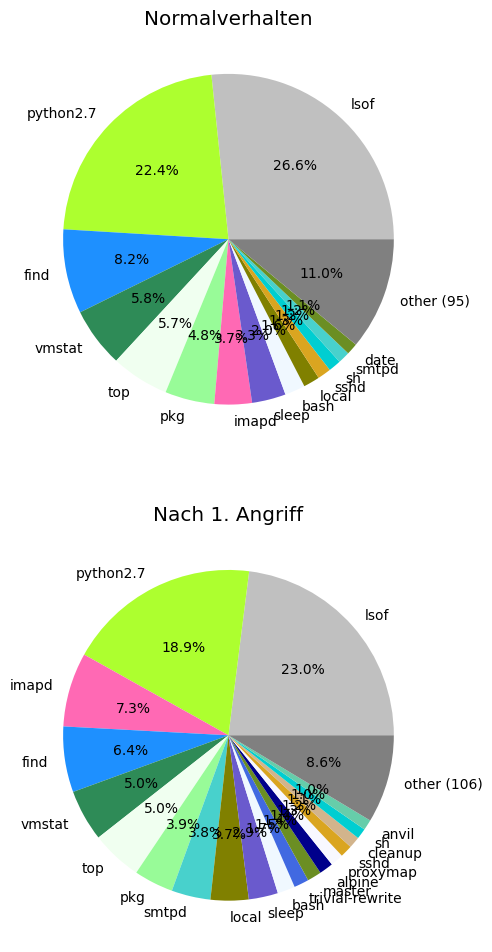

In [83]:
# get len(executables) + 1 colors from tab20 colormap
colors = []
# numpy seed
np.random.seed(4)
while len(colors) <= len(executables):
    # add random color from XKCD_COLORS
    colors.append(mcolors.CSS4_COLORS[np.random.choice(list(mcolors.CSS4_COLORS.keys()))])
# map executables to colors
executable_colors = { e: colors[i] for i, e in enumerate(executables) }
def get_color(executable):
    return executable_colors[executable] if executable in executable_colors else colors[-1]


# plot 2 pie charts, one above the other, aim for a4 size
# 10 cm width, 15 cm height
fig, ax = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.2)

# plot benign
ax[0].pie(executables_b[1], labels=executables_b[0], autopct='%1.1f%%', colors=[get_color(e) for e in executables_b[0]], textprops={'size': 'small'})
ax[0].set_title('Normalverhalten')
# plot unknown
ax[1].pie(executables_u[1], labels=executables_u[0], autopct='%1.1f%%', colors=[get_color(e) for e in executables_u[0]], textprops={'size': 'small'})
ax[1].set_title('Nach 1. Angriff')

fig.set_size_inches((20 * cm, 30 * cm))

# save as svg
plt.savefig('figures/executable_events_distribution_vs.svg')

plt.show()